In [214]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [215]:
layer_num=3
hidden_num=64

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [216]:
def potential(x):
    poten=x*torch.sin(torch.pi*x/2.5)*10+x**4/25
    return poten

In [217]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-10
Lb =10
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=120
extend_num=0
lr=0.01
# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


/tmp/ipykernel_385925/2513471731.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


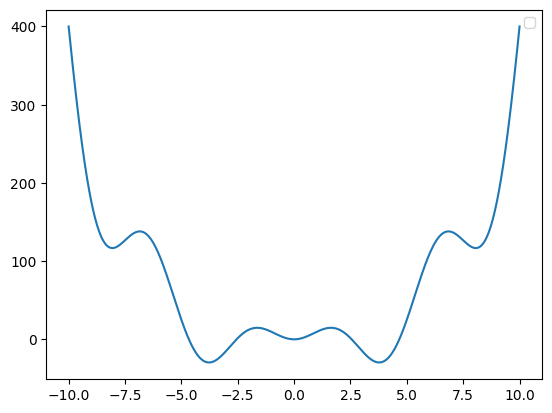

In [218]:
# 势函数演示图像
x_test=torch.linspace(La, Lb, N+2)
f1_test=potential(x_test)
plt.plot(x_test.numpy(), f1_test.numpy())
plt.legend()
plt.show()

In [219]:
# 计算初始的本征值
V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

print('initial eigenvalues check:')
print(eigenvalues[:en_num])

en=eigenvalues[:en_num]

initial eigenvalues check:
tensor([-25.5755, -25.5754, -17.6883, -17.6863, -10.1369, -10.1330,  -2.9682,
         -2.9645,   2.4042,   3.7295,   3.7366,   6.9747,   9.8012,   9.8062,
         11.0052,  13.9927,  14.7249,  15.3311,  17.2603,  18.9087,  20.4927,
         22.3332,  24.2871,  26.3127,  28.4325,  30.6227,  32.8950,  35.2337,
         37.6403,  40.1069,  42.6389,  45.2169,  47.8559,  50.5395,  53.2677,
         56.0478,  58.8721,  61.7304,  64.6186,  67.5566,  70.5137,  73.5108,
         76.5369,  79.5756,  82.6442,  85.7305,  88.8415,  91.9591,  95.0878,
         98.2309, 101.3761, 104.5218, 107.6651, 110.7996, 113.9276, 117.0344,
        120.1124, 121.3688, 121.3688, 123.1604, 126.1610, 129.0969, 130.2016,
        130.2037, 131.9519, 134.6452, 136.8163, 137.5098, 138.1262, 139.9621,
        141.8787, 143.4897, 145.0435, 146.7746, 148.6378, 150.5385, 152.4584,
        154.4204, 156.4277, 158.4787, 160.5627, 162.6830, 164.8344, 167.0187,
        169.2357, 171.4804, 173.7566,

In [220]:
a_60_20000=torch.tensor([-25.5773, -25.5773, -17.6901, -17.6901, -10.1357, -10.1357,  -2.9693,
         -2.9692,   2.4038,   3.7314,   3.7315,   6.9714,   9.7997,   9.8008,
         11.0059,  13.9739,  14.7265,  15.3383,  17.2664,  18.9094,  20.4862,
         22.3308,  24.2869,  26.3123,  28.4259,  30.6189,  32.8919,  35.2313,
         37.6349,  40.1074,  42.6319,  45.2131,  47.8486,  50.5333,  53.2652,
         56.0447,  58.8614,  61.7203,  64.6133,  67.5464,  70.5082,  73.5020,
         76.5217,  79.5641,  82.6336,  85.7232,  88.8250,  91.9455,  95.0747,
         98.2149, 101.3618, 104.5033, 107.6478, 110.7838, 113.9078, 117.0152,
        120.0915, 121.3677, 121.3678, 123.1416, 126.1434, 129.0782, 130.1996,
        130.1999, 131.9299, 134.6271, 136.8091, 137.5072, 138.1092, 139.9442,
        141.8662, 143.4763, 145.0266, 146.7559, 148.6212, 150.5217, 152.4404,
        154.3980, 156.4083, 158.4574, 160.5415, 162.6595, 164.8094, 166.9959,
        169.2114, 171.4545, 173.7279, 176.0301, 178.3611, 180.7197, 183.1048,
        185.5126, 187.9512, 190.4117, 192.8976, 195.4070, 197.9358, 200.4937,
        203.0721, 205.6764, 208.2993, 210.9483, 213.6140, 216.3058, 219.0185,
        221.7469, 224.4995, 227.2705, 230.0638, 232.8805, 235.7141, 238.5675,
        241.4373, 244.3310, 247.2381, 250.1709, 253.1144, 256.0810, 259.0672,
        262.0723],dtype=dtype,device=device)
b_80_24000=torch.tensor([-25.5641, -25.5604, -17.7105, -17.7065, -10.1362, -10.1307,  -2.9644,
         -2.9567,   2.4229,   3.7268,   3.7274,   6.9811,   9.8061,   9.8215,
         11.0020,  13.9858,  14.7248,  15.3573,  17.2419,  18.8840,  20.5120,
         22.3188,  24.2656,  26.3396,  28.4383,  30.5568,  32.9279,  35.2241,
         37.6249,  40.0920,  42.6319,  45.1928,  47.8346,  50.5227,  53.2590,
         56.0235,  58.8764,  61.7192,  64.5973,  67.5525,  70.5044,  73.4876,
         76.5285,  79.5410,  82.6325,  85.7279,  88.8047,  91.9291,  95.0554,
         98.2206, 101.3723, 104.4860, 107.6571, 110.7886, 113.8847, 116.9897,
        120.0744, 121.3781, 121.3786, 123.1307, 126.1235, 129.0683, 130.1905,
        130.1920, 131.9104, 134.6281, 136.7848, 137.5056, 138.1196, 139.9424,
        141.8569, 143.4493, 145.0150, 146.7542, 148.6324, 150.5022, 152.4159,
        154.3790, 156.3861, 158.4521, 160.5129, 162.6328, 164.7686, 166.9875,
        169.2064, 171.4672, 173.7081, 175.9915, 178.3402, 180.6902, 183.0857,
        185.4880, 187.9133, 190.3916, 192.8762, 195.3898, 197.9125, 200.4627,
        203.0347, 205.6429, 208.2670, 210.9127, 213.5799, 216.2721, 218.9841,
        221.7181, 224.4649, 227.2289, 230.0161, 232.8300, 235.6720, 238.5267,
        241.3997, 244.2861, 247.1827, 250.1220, 253.0659, 256.0272, 259.0146,
        262.0085], dtype=dtype,device=device)
c_10_24000=torch.tensor([-24.2475, -23.9030, -17.7461, -15.7078, -10.2184, -10.0965,  -4.2636,
         -2.3676,   3.3120,   4.4139,   5.1977,   8.7228,  10.1115,  11.5908,
         11.8919,  12.0621,  13.4403,  15.4255,  18.3514,  18.5857,  19.7545,
         20.5302,  25.2951,  25.4250,  29.9438,  31.7552,  32.3088,  33.7152,
         38.2883,  39.3608,  43.0445,  46.3885,  48.6130,  48.8812,  52.9351,
         57.0371,  59.1597,  60.1432,  64.9199,  67.3905,  71.0765,  72.9450,
         76.5769,  79.0557,  82.9198,  86.8331,  87.3593,  92.4155,  95.6394,
         98.6300, 100.7029, 105.1415, 108.3440, 111.3788, 113.4010, 118.0117,
        120.3647, 122.1309, 123.2607, 123.2623, 125.6673, 129.6767, 129.9646,
        130.0000, 132.5852, 135.4353, 135.8633, 136.3696, 138.9276, 140.5628,
        142.3343, 142.9372, 144.9907, 147.3540, 149.0485, 151.5790, 152.9514,
        154.1610, 156.7939, 156.8606, 159.9258, 163.3086, 164.1776, 167.0715,
        170.1214, 170.4850, 174.9613, 175.6025, 177.9729, 180.9730, 182.8691,
        185.1689, 188.9276, 189.9550, 192.8860, 196.5858, 197.3487, 200.8832,
        202.7545, 206.0248, 209.1469, 210.3704, 213.4985, 217.1882, 218.3388,
        221.7494, 225.3120, 227.1626, 230.3421, 233.6647, 235.9028, 239.4592,
        241.5606, 243.7826, 247.6924, 250.6159, 252.3837, 256.5690, 259.3304,
        262.5206], dtype=dtype,device=device)
d_10_3000=torch.tensor([-25.5775, -25.5774, -17.6892, -17.6891, -10.1361, -10.1360,  -2.9692,
         -2.9690,   2.4016,   3.7313,   3.7327,   6.9734,   9.7985,   9.7991,
         11.0023,  13.9661,  14.7494,  15.3219,  17.2688,  18.9108,  20.4834,
         22.3310,  24.2866,  26.3091,  28.4237,  30.6195,  32.8902,  35.2292,
         37.6341,  40.1018,  42.6298,  45.2116,  47.8474,  50.5314,  53.2612,
         56.0363,  58.8555,  61.7141,  64.6106,  67.5392,  70.4998,  73.4915,
         76.5129,  79.5604,  82.6284,  85.7135,  88.8172,  91.9364,  95.0663,
         98.2050, 101.3482, 104.4930, 107.6357, 110.7707, 113.8944, 116.9989,
        120.0789, 121.3663, 121.3675, 123.1256, 126.1257, 129.0616, 130.2027,
        130.2029, 131.9168, 134.6121, 136.7947, 137.5042, 138.1086, 139.9327,
        141.8542, 143.4665, 145.0171, 146.7467, 148.6083, 150.5070, 152.4268,
        154.3868, 156.3953, 158.4422, 160.5238, 162.6445, 164.7957, 166.9754,
        169.1907, 171.4347, 173.7072, 176.0098, 178.3419, 180.7000, 183.0837,
        185.4911, 187.9246, 190.3861, 192.8709, 195.3803, 197.9126, 200.4661,
        203.0425, 205.6429, 208.2672, 210.9132, 213.5816, 216.2699, 218.9796,
        221.7105, 224.4615, 227.2338, 230.0263, 232.8385, 235.6702, 238.5217,
        241.3925, 244.2824, 247.1920, 250.1193, 253.0661, 256.0306, 259.0138,
        262.0155], dtype=dtype,device=device)

In [221]:
error=en-b_80_24000
error_2=en-c_10_24000
error_3=en-d_10_3000

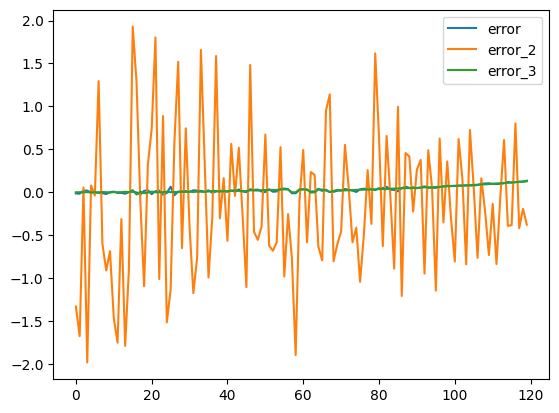

In [222]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(error_2.detach().cpu().numpy(),label='error_2')
plt.plot(error_3.detach().cpu().numpy(),label='error_3')
plt.legend()
plt.show()